In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
ticker = "NVDA"
df = yf.download(ticker, start='2025-01-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Bollinger Bands
# Example: Middle = SMA20; Upper = Middle + 2StdDev; Lower = Middle - 2StdDev.

def calculate_bollinger_bands(df: pd.DataFrame, period: int = 20, std_dev: float = 2.0, column: str = 'Close') -> pd.DataFrame:
    """
    Parameters:
    - df: DataFrame with price data.
    - period: for SMA and std (default 20).
    - std_dev: multiplier (default 2).
    - column: yf data column to use (default 'Close').
    
    Returns:
    - DataFrame with 'upper', 'middle', 'lower'.
    
    Interpretation: Price at upper = overbought; squeezes signal volatility expansion.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not in DataFrame.")
    if len(df) < period:
        raise ValueError(f"DataFrame must have at least {period} rows.")
    
    middle = df[column].rolling(window=period).mean()
    std = df[column].rolling(window=period).std()
    upper = middle + std_dev * std
    lower = middle - std_dev * std
    return pd.DataFrame({'upper': upper.values.flatten(), 'middle': middle.values.flatten(), 'lower': lower.values.flatten()}, index=df.index)
    

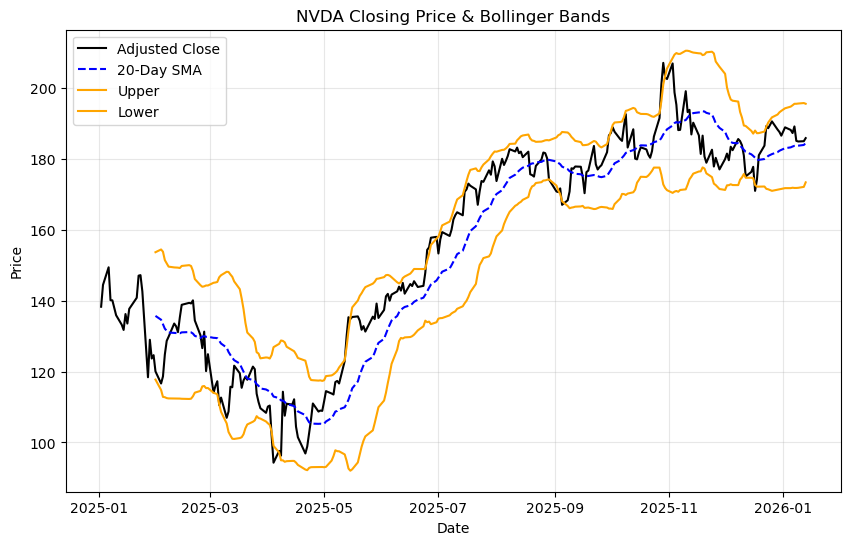

In [4]:
# Example (Bollinger)

bollinger_period = 20
bollinger_std = 2
BOLLINGER = calculate_bollinger_bands(df, bollinger_period, bollinger_std)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Adjusted Close', color='black')
plt.plot(df.index, BOLLINGER['middle'], label=f"{bollinger_period}-Day SMA", color='blue', linewidth=1.5, linestyle='--')
plt.plot(df.index, BOLLINGER['upper'], label="Upper", color='orange', linewidth=1.5)
plt.plot(df.index, BOLLINGER['lower'], label="Lower", color='orange', linewidth=1.5)
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.title(f"{ticker} Closing Price & Bollinger Bands")
plt.show()

In [5]:
# Average True Range (ATR)
# True Range (TR) = Max{Current High - Current Low, |Current High - Previous Close|, |Current Low - Previous Close|}.
# Average True Range ATR = EMA of TR, or ATR(t) = (ATR(t-1) x (n-1) + TR(t)) / n according to Wikipedia.

def calculate_atr(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """
    Parameters:
    - df: DataFrame with 'High', 'Low', 'Close'.
    - period: window size (default 14).
    
    Returns:
    - Series with ATR values.
    
    Interpretation: High ATR = volatile; use for trailing stops (e.g., 2*ATR below price).
    """
    required_cols = ['High', 'Low', 'Close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns: High, Low, Close.")
    if len(df) < period + 1:
        raise ValueError(f"DataFrame must have at least {period + 1} rows.")
    
    tr = np.maximum(df['High'] - df['Low'], np.maximum(abs(df['High'] - df['Close'].shift()), abs(df['Low'] - df['Close'].shift())))
    atr = tr.ewm(span=period, adjust=False).mean()
    return atr


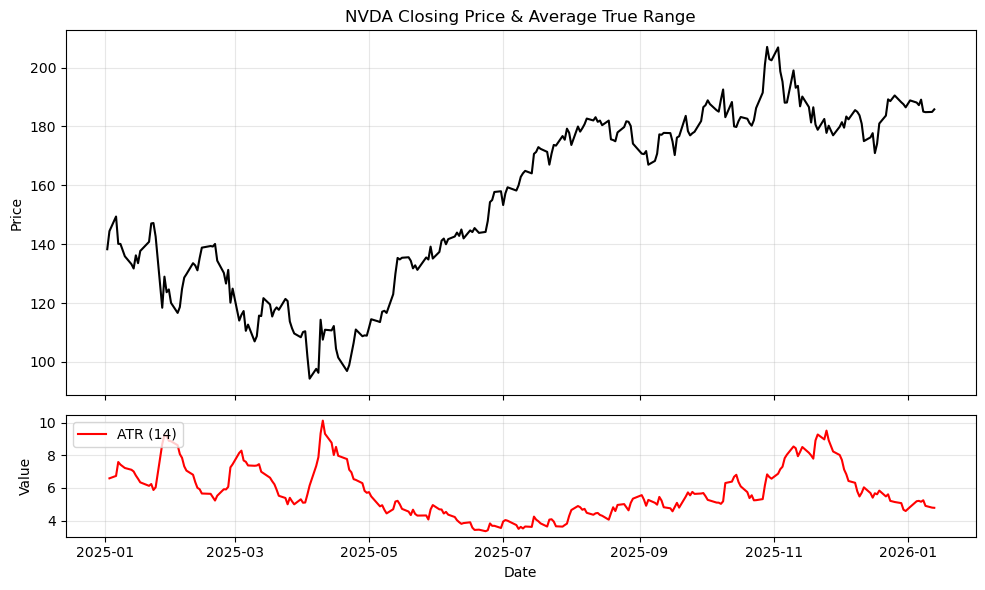

In [6]:
# Example (ATR)

atr_period = 14
ATR = calculate_atr(df, atr_period)

# Plot
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(10, 6),
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

ax1.plot(df.index, df['Close'], label='Adjusted Close', color='black')
ax1.set_ylabel('Price')
ax1.grid(True, alpha=0.3)
ax1.set_title(f'{ticker} Closing Price & Average True Range')

ax2.plot(df.index, ATR, label=f'ATR ({atr_period})', color='red')
ax2.set_ylabel('Value')
ax2.set_xlabel('Date')
plt.grid(True, alpha=0.3)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()